<a href="https://colab.research.google.com/github/Rudi3601/CHC_Thesis/blob/main/Deep_Portfolio_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [ ]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

#from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt

Trajectories for Black Scholes Model

In [ ]:
# Trajectories of the Black scholes model
# Let it run to initialize the following parameters, the trajectories
# are not needed afterwards

N=30 # time disrectization
S0=1 # initial value of the asset
X0=1  # initial wealth
T=1 # maturity
sigma=0.2 # volatility in Black Scholes
mu=0.1
r=0.0
gamma=0.0
R=10**5 # number of Trajectories

logS= np.zeros((N,R))
logS[0,]=np.log(S0)*np.ones((1,R))

for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(mu*T/N-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
        logS[j+1,i] =logS[j,i]+increment

S=np.exp(logS)

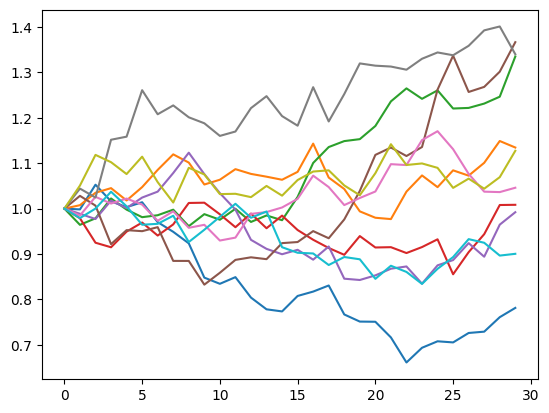

In [ ]:
for i in range(10):
   plt.plot(S[:,i])
plt.show()

In [ ]:
logX= np.zeros((N+1,R))
logX[0,]=np.log(X0)*np.ones((1,R))
alpha= (mu-r)/(sigma**2*(1-gamma))
for i in range(R):
    for j in range(N):
        increment = np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N))
        logX[j+1,i] =logX[j,i]+increment*alpha+r*T/N*(1-alpha)-alpha**2*sigma**2*T/(2*N)

X=np.exp(logX)
loss=np.mean(-np.log(X[N,:]))# np.mean(-(X[N-1,:]**gamma))
print(loss)

-0.12603233408979544


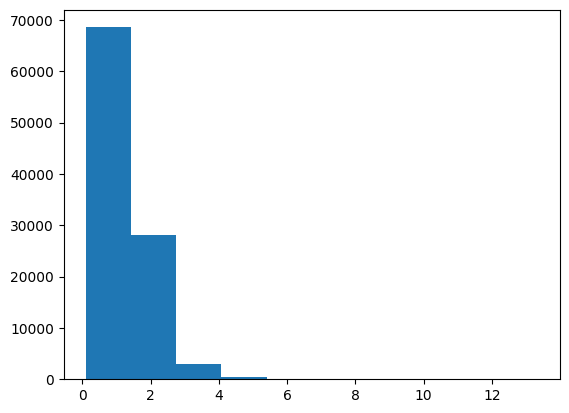

1.2741700886736196
0.6674477849869496


In [ ]:
plt.hist(X[N-1,:])
plt.show()
print(np.mean(X[N-1,:]))
print(np.std(X[N-1,:]))

Definition of NN for trading strategies

In [ ]:
#Definition of neural networks for trading strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                          bias_initializer=initializers.RandomNormal(0,0.5),
                          name=str(i)+str(j))
        layers = layers + [layer]

In [ ]:
# Implementing the outcoming of trading via neural networks
# Inputs is the training set below, containing the price S0,
# again we record the trading strategies on separate input variables 'tradeeval' to read them out easily later
price = Input(shape=(m,))
trade = Input(shape=(m,))
tradeeval = Input(shape=(m,))
wealth = Input(shape=(1,))

inputs = [price]+[trade]+[tradeeval]+[wealth]
outputhelper=[]

for j in range(N):
    strategy = wealth
    strategyeval=tradeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the alpha at j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)
    price=pricenew
    logwealth= Lambda(lambda x : K.log(x))(wealth)
    logwealth= Lambda(lambda x : x+r*T/N)(logwealth)
    helper1 = Multiply()([strategy, incr])
    #helper1 = Lambda()(lambda x : K.sum(x,axis=1))([helper1])
    logwealth = Add()([logwealth, helper1])
    helper2 = Multiply()([strategy, strategy])
    #helper2 = Lambda()(lambda x : K.sum(x,axis=1))([helper1])
    helper3 = Lambda(lambda x : x*sigma**2/2*T/N)(helper2)
    logwealth = Subtract()([logwealth, helper3])
    helper4 = Lambda(lambda x : x*r*T/N)(strategy)
    logwealth = Subtract()([logwealth, helper4])
    wealthnew=Lambda(lambda x : K.exp(x))(logwealth)# creating the wealth at time j+1
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval] # here we collect the strategies
    wealth=wealthnew
outputs = wealth
randomendowment = Lambda(lambda x : -0.0*(K.abs(x-1.0)+x-1.0))(price)
outputs = Add()([wealth,randomendowment])
outputs = [outputs] + outputhelper
outputs = Concatenate()(outputs)

model_Merton = Model(inputs=inputs, outputs=outputs)

In [ ]:
Ktrain = 10**5
initialprice = S0
initialwealth = X0
# xtrain consists of the price S0,
#the initial hedging being 0, and dummy variables hedgeeval where the strategies are evaluated,
#the initial wealth and the increments of the log price process
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [1*np.ones((Ktrain,m))] +
          [initialwealth*np.ones((Ktrain,m))] +
          [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [ ]:
def custom_loss(y_true,y_pred):
    z = - K.log(y_pred[:,0])#-((y_pred[:,0]**gamma-1)/gamma
    z=K.mean(z)
    return z
#def custom_loss(y_true,y_pred):
#    z = K.exp(- y_pred[:,0]*ra)#
#    z=K.mean(z)
#    return z

In [ ]:
from keras import optimizers

#adam=optimizers.Adam(lr=0.01)

model_Merton.compile(optimizer='adam',loss=custom_loss)

In [ ]:
import matplotlib.pyplot as plt

for i in range(1):
    model_Merton.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=100)

Epoch 1/10
1000/1000 [==============================] - 51s 22ms/step - loss: -0.1181
Epoch 2/10
1000/1000 [==============================] - 23s 23ms/step - loss: -0.1222
Epoch 3/10
1000/1000 [==============================] - 23s 23ms/step - loss: -0.1226
Epoch 4/10
1000/1000 [==============================] - 24s 24ms/step - loss: -0.1233
Epoch 5/10
1000/1000 [==============================] - 22s 22ms/step - loss: -0.1235
Epoch 6/10
1000/1000 [==============================] - 21s 21ms/step - loss: -0.1236
Epoch 7/10
1000/1000 [==============================] - 23s 23ms/step - loss: -0.1237
Epoch 8/10
1000/1000 [==============================] - 22s 22ms/step - loss: -0.1237
Epoch 9/10
1000/1000 [==============================] - 23s 23ms/step - loss: -0.1241
Epoch 10/10
1000/1000 [==============================] - 23s 23ms/step - loss: -0.1240


In [ ]:
y_pred = model_Merton.predict(xtrain)
print(np.mean(-np.log(y_pred[:,0])))

logX= np.zeros((N+1,R))
logX[0,]=np.log(X0)*np.ones((1,R))
alpha= (mu-r)/(sigma**2*(1-gamma))
for i in range(R):
    for j in range(N):
        increment = xtrain[4+j][i] #np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N))
        logX[j+1,i] =logX[j,i]+increment*alpha+r*T/N*(1-alpha)-alpha**2*sigma**2*T/(2*N)

X=np.exp(logX)
loss=np.mean(-np.log(X[N,:]))# np.mean(-(X[N-1,:]**gamma))
print(loss)

3125/3125 [==============================] - 32s 8ms/step
-0.1245384
-0.12508606880026193


3125/3125 [==============================] - 24s 8ms/step


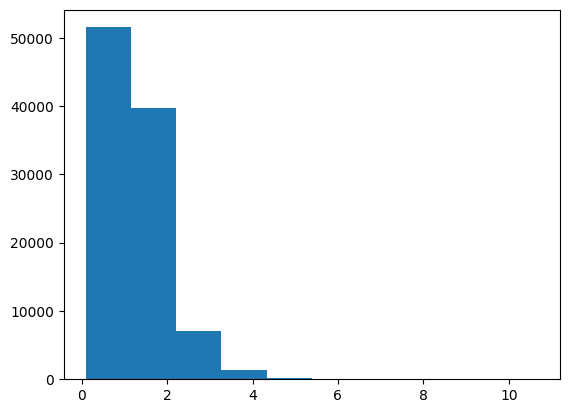

3125/3125 [==============================] - 25s 8ms/step
1.283073
3125/3125 [==============================] - 24s 8ms/step
0.680072


In [ ]:
plt.hist(model_Merton.predict(xtrain)[:,0])
plt.show()
print(np.mean(model_Merton.predict(xtrain)[:,0]))
print(np.std(model_Merton.predict(xtrain)[:,0]))

In [ ]:
k=10#Choose a number between 1 and N-1
Ktest=60
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [0.7*np.ones((Ktest,m))+np.cumsum(np.ones((Ktest,m))*(1.5-0.7)/Ktest,axis=0)] +#change this if you go to higher dimensions
          [initialwealth*np.ones((Ktest,m))]+
          [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktest,m)) for i in range(N)])

2/2 [==============================] - 0s 10ms/step


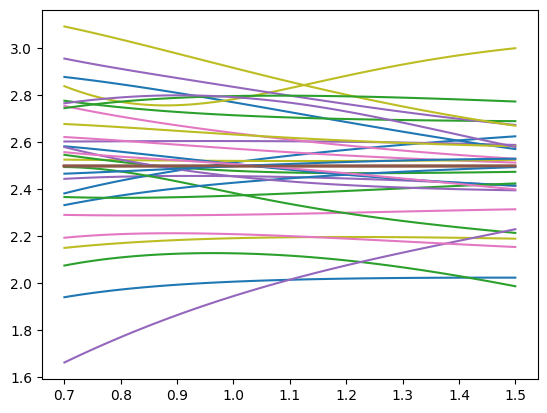

2.4999999999999996


In [ ]:
#Comparison of learned and true alpha
s=np.linspace(0.7,1.5,Ktest)

for k in range(1,N-1):
    truestrat=(mu-r)/(sigma**2*(1-gamma))*np.ones(Ktest)
    learnedstrat=model_Merton.predict(xtest)[:,k]
    plt.plot(s,learnedstrat,s,truestrat)
plt.show()
print((mu-r)/(sigma**2*(1-gamma)))